# Michał Matak - SVM do mapowania obiektu



### Importowanie bibliotek
* numpy - operacje na macierzach 
* scipy - optymalizacja parametryczna
* matplotlib - tworzenie wykresów

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from data_operations import get_data, split_into_classes, split_into_sets, get_dictionary_axes, test, create_heatmap
import matplotlib.pyplot as plt
import random

In [2]:
def encode(number, data_dictionary):
    vector = -np.ones(len(data_dictionary))
    vector[number-1] = 1
    return vector

def decode(vector):
    return np.argmax(vector) + 1

In [3]:
def make_3D_set(index, data):
    data_set = np.array([[row[0][0], row[0][1], row[0][2], row[1][index]] for row in data])
    return data_set

### Dekodowanie

In [4]:
data, data_dictionary = get_data("series2", encode)

In [5]:
x = encode(2, data_dictionary)
print(x)
print(decode(x))

[-1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
2


### Funkcje związane z SVM

Funkcja realizująca SVM **linear_SVM** przyjmuje jako argument zbiór z elementami postaci \[atrybuty, przynależność (1 lub -1) do danej klasy\] i zwraca **w** oraz **b** wyznaczające hiperpłaszczyznę dzielącą zbiór.  
Zmiennymi globalnymi są **TRAIN_SET**, **RECORD_SIZE** oraz **LAMBDA**, oznaczające odpowiednio wielkość podanego zbioru, ilość atrybutów dla elementu w zbiorze oraz $\lambda$. Zmienne te są globalne aby nie było potrzeby przekazywania ich jako parametry, do funkcji, która będzie minimalizowana (uznawała by je ona za zmienne i według nich szukała minimum).
Funkcja minimize zaimportowana z biblioteki SciPy wykorzystuje poniżej zdefiniowane funkcje **constraint** oraz **target**.

In [6]:
def linear_SVM(train_set):
    global TRAIN_SET
    global RECORD_SIZE
    global LAMBDA
    LAMBDA = 0.5
    TRAIN_SET = train_set
    RECORD_SIZE = len(TRAIN_SET[0]) - 1
    constraint = NonlinearConstraint(constraint1, np.zeros(len(TRAIN_SET)), np.inf)
    res = minimize(target, np.random.random(RECORD_SIZE + 1), constraints=constraint)
    w = res.x[:RECORD_SIZE]
    b = res.x[RECORD_SIZE]
    return w, b

Funkcja **target** jest równoważna:  

<center>$\sum_i\zeta_i + \lambda \|w\|$</center>
  
      
    
  
która jest minimalizowana dla argumentów *w* i *b* przez **minimize**. Argumenty te są zebrane w jednej liście aby funkcja optymalizująca mogła działać. 

In [7]:
def target(w):
    return np.linalg.norm(w[:RECORD_SIZE], 2)*LAMBDA + dzeta(w).sum()

Na minimalizację powyższej funkcji nałożone są warunki:  
<center>$y_i(w^Tx - b)\geq 1 - \zeta_i$ </center>  
Co jest równoważne:  
<center>$y_i(w^Tx - b) - 1 + \zeta_i\geq 0 $ </center>  
Operacja ta w funkcji constarint jest wykonywana od razu dla całej macierzy, gdzie $\zeta$ jest obliczane od razu jako wektor.

In [8]:
def constraint1(w):
    return ((np.matmul(TRAIN_SET[:, :RECORD_SIZE], w[:RECORD_SIZE]) - w[RECORD_SIZE]) * TRAIN_SET[:, RECORD_SIZE]) + \
            dzeta(w) - np.ones(len(TRAIN_SET))

Funkcja **dzeta** wykonuje operację:
<center>$\zeta_i = max(1 - f(x_i)y_i, 0)$</center>  
dla każdego elementu macierzy z danymi i zwraca wynik jako wektor.


In [9]:
def dzeta(w):
    return np.maximum(np.zeros(len(TRAIN_SET)), np.ones(len(TRAIN_SET)) - ((np.matmul(TRAIN_SET[:, :RECORD_SIZE], w[:RECORD_SIZE]) - w[RECORD_SIZE]) * TRAIN_SET[:, RECORD_SIZE]))

### Uczenie SVM - program

Dane są ładowane do listy data, następnie tworzony jest zbiór testowy, który zostaje podzielony na 3 grupy. Uczone są 3 SVM (porównują zbiory 1 z 2, 2 z 3 i 3 z 1), które zwracają parametry *w* i *b* a ich wyniki są przekazywane do funkcji **predict**.

In [10]:
def train_svm(data_dictionary, class_vector):
    parameters_array = [[[] for _ in range (len(data_dictionary))] for _ in range (len(data_dictionary))] 
    for i in range (len(data_dictionary)):
        for j in range (len(data_dictionary)):
            if i!=j:
                parameters_array[i][j] = linear_SVM(make_3D_set(i, class_vector[i] + class_vector[j]))
    return parameters_array

#### Funkcja predict

Funkcja **predict** przyjmuje jako argument atrybuty elementu zbioru i na ich podstawie decyduje do jakiej klasy należy dany element. Robi to instrukcjami warunkowymi (jeśli widzi, że dla porównań 1 z 2 i 1 z 3 oba wskazania są na 1 to zwraca macierz odpowiadającą elementowi klasy pierwszej, analogicznie dla pozostałych zbiorów). Sytuację, w której porówniane 1 z 2 wskazuje na 2, 2 z 3 na 2 i 3 z 1 na 1 pozostawiłem nierozstrzygnięte. Porównania między dwoma klasami odbywają się za pomocą obliczenia $wx - b$ i zwrócenia 1 jeśli wynik jest większy niż 0 lub -1 jeśli mniejszy.

Funkcja progowa unipolarna zwraca 1 jeśli *x* jest większy lub równy *a* i -1 jeśli *x* jest mniejszy od *a*  

In [11]:
def threshold_unipolar_function(x, a):
    if (x >= a):
        return 1
    elif (x < a):
        return -1

In [12]:
def predict(element, parameters_array):
    for i in range (len(data_dictionary)):
        pred_vector = [(threshold_unipolar_function(np.matmul(parameters_array[i][j][0], element) - parameters_array[i][j][1], 0)) 
                       for j in range(len(data_dictionary)) if i!=j]
#         print(pred_vector)
        if pred_vector == list(np.ones(len(data_dictionary)-1)):
            return i+1
    return 0

### Ewaluacja - sprawdzenie działania algorytmu

Poniżej znajduje się fragment programu, który sprawdza stopień poprawnośći przewidywań przez SVM. Zbiór testowy jest podzielony na 3 klasy i dla każdej klasy przewidywana jest jej klasa na podstawie modelu. Jeśli model się pomylił dodawana jest jedynka do liczby błędów.

In [13]:
data, data_dictionary = get_data("series2", encode)
train_set, test_set = split_into_sets(0.9, data)
class_vector = split_into_classes(data, data_dictionary, decode)

In [14]:
parameters_array = train_svm(data_dictionary, class_vector)

In [15]:
classes_vector = split_into_classes(test_set, data_dictionary, decode)
total_errors = 0
for element in data_dictionary.values():
    errors = 0
    for row in classes_vector[element-1]:
        if predict(row[0], parameters_array) != element:
            errors += 1
    total_errors += errors
    print(f"Class {element}: accuracy {(1 - errors/len(classes_vector[element-1]))*100:.2f}%")
total_accuracy = (1 - (total_errors)/(len(test_set)))*100
print(f"Total accuracy {total_accuracy:.2f}%")

Class 1: accuracy 0.00%
Class 2: accuracy 100.00%
Class 3: accuracy 100.00%
Class 4: accuracy 100.00%
Class 5: accuracy 0.00%
Class 6: accuracy 0.00%
Class 7: accuracy 100.00%
Class 8: accuracy 97.85%
Class 9: accuracy 100.00%
Class 10: accuracy 95.83%
Class 11: accuracy 82.08%
Class 12: accuracy 100.00%
Class 13: accuracy 54.05%
Class 14: accuracy 100.00%
Class 15: accuracy 0.00%
Total accuracy 68.27%


In [16]:
"""
Sample test
"""
for _ in range(10):
    x = random.choice(data)
    print(decode(x[1]), predict(x[0], parameters_array))
    


15 10
12 12
13 0
12 12
12 12
15 10
11 11
12 12
15 10
10 10


In [17]:
classification_array = test(class_vector, predict, [parameters_array])

'\nNa jakie klasy został zakwalifikowany obiekt klasy tytułowej\n'

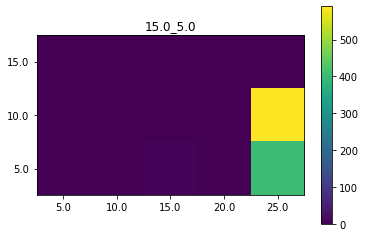

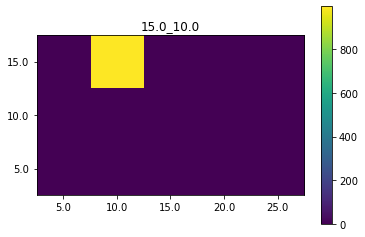

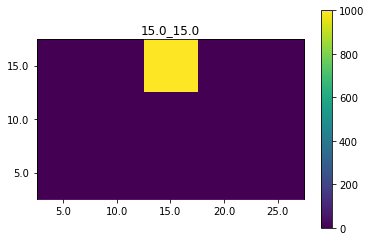

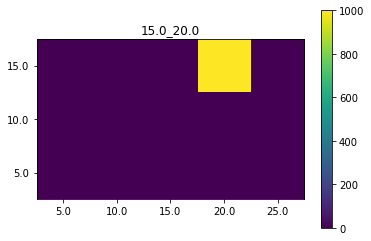

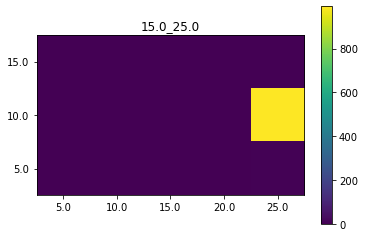

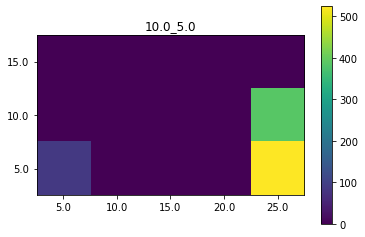

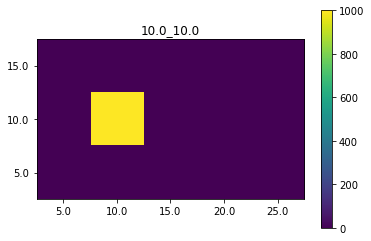

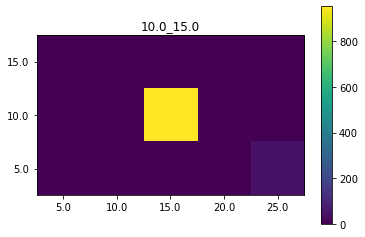

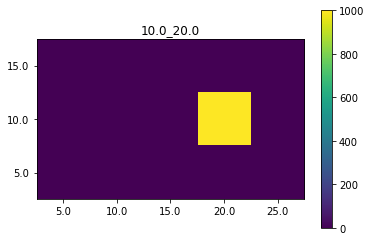

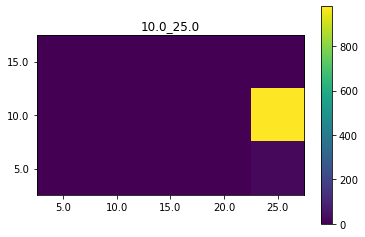

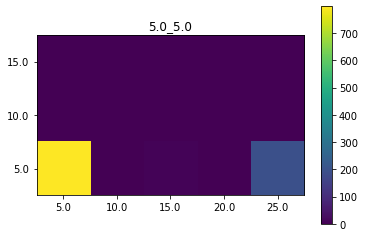

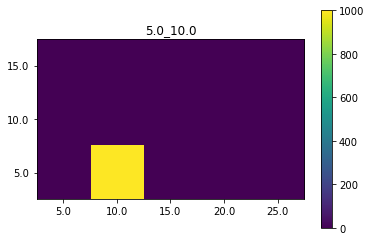

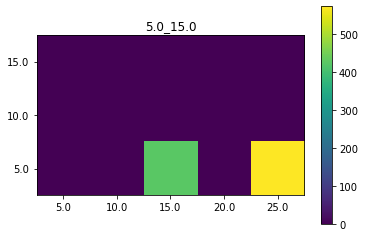

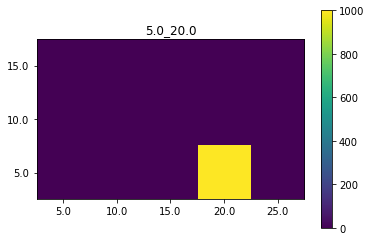

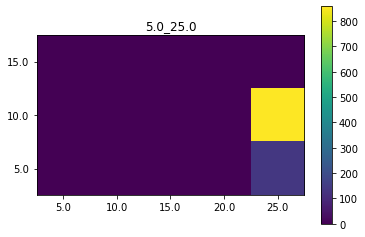

In [18]:
for class_name in data_dictionary:
    create_heatmap(class_name, data_dictionary, classification_array)
"""
Na jakie klasy został zakwalifikowany obiekt klasy tytułowej
"""